# Pré processamento de dados

Aqui, buscaremos processar e analisar os dados do banco de dados da SSP/SP no âmbito de lesão corporal seguida de morte (LCSM) para a cidade de São Paulo.

## Lendo os dados

Primeiramente, carregamos as planilhas do arquivo em dataframes na memória.

Depois, retiramos as colunas onde todos os dados são nulos, pois nas planilhas há algumas colunas que não há dados, provavelmente inseridas ali para organizar a planilha.

Depois, unimos todos os dataframes das planilhas em um só, considerando que não precisamos colocar o ano em cada visto que já existe uma coluna especificando o ano.

In [84]:
import pandas as pd

with pd.ExcelFile('LCSM_2016_2022.xlsx') as lcsm:
    lcsm_sheets = pd.read_excel(lcsm, None)
    sheets = list(lcsm_sheets.values())

for i, sheet in enumerate(sheets):
    cols = ~sheet.isnull().all()
    sheets[i] = sheet[cols.index[cols]]

sheet = pd.concat(sheets)

## Tratando strings

Em seguida, vamos tratar as strings.

O problema principal com relação a strings é o fato de que o modelo pode achar que há duas palavras diferentes quando são a mesma palavra com uma diferença de maiúsculas, minúsculas, de unicode, ou até problemas com espaços entre palavras.

Para resolver esse problema, desejamos buscar uma maneira de fazer um mapeamento das strings originais para strings diferentes da forma mais determinística possivel, para prevenir que casos como esses ocorram.

As transformações que faremos aqui na string serão:

1. Normalizar caracteres unicode: Isso evita problemas no unicode onde dois caracteres com diacríticos são vistos como diferentes por um ser apenas um caractere com o seu próprio unicode e o outro ser o caractere simples com o caractere do diacrítico adicionado. Normalizaremos para o segundo caso, onde usa-se o caractere simples e adiciona-se diacríticos a esse usando os caracteres específicos destes, visto que isso será usado para o próximo passo;
2. Remover caracteres com diacríticos: Isso evita que palavras com ou sem diacríticos sejam vistas como diferentes quando são a mesma (essa etapa remove tanto acentuações quanto diacríticos como o cedilha);
3. Tornar todos os caracteres minúsculos: Para evitar problemas de maiúsculas ou minúsculas como justificado anteriormente;
4. Normalizar espaços: Serve para padronizar os dados.

In [85]:
import unicodedata as ud
import re

def process_string(s):
    if not isinstance(s, str):
        return s
    
    s = ud.normalize('NFD', s)
    s = re.sub(r'[\u0300-\u036f]', '', s)
    s = s.lower()
    s = ' '.join(s.split())
    return s


sheet = sheet.applymap(process_string)

## Filtrando dados relevantes

Agora, nós buscamos filtrar os dados relevantes para o dataset.

Precisamos usar apenas os dados da cidade de São Paulo, portanto vamos filtrar para os crimes apenas da cidade.

In [86]:
sheet = sheet.loc[sheet['MUNICIPIO_ELABORACAO'] == 's.paulo']

## Separando dados relevantes

Agora, desejamos extrair, dos dados que já temos, dados que podem exibir padrões quando vistos separadamente.

Nesse caso, iremos criar uma coluna separada para o dia da semana em que ocorreu o crime.

In [87]:
import datetime as dt

def weekday_parse(d):
    if not isinstance(d, dt.datetime):
        return None

    return pd.to_datetime(d, format='%Y-%m-%d %H:%M:%S').weekday()

sheet['DIA_SEMANA'] = sheet['DATA_FATO'].apply(weekday_parse)

# Exibindo dados

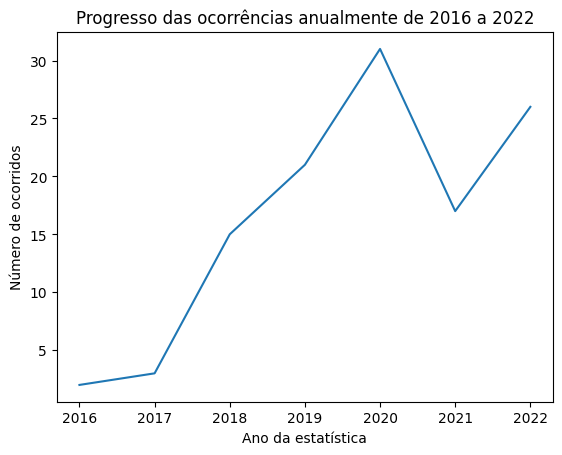

In [88]:
from matplotlib import pyplot as plt

df = sheet.groupby('ANO ESTATISTICA')['ANO ESTATISTICA'].count()
df.plot(title="Progresso das ocorrências anualmente de 2016 a 2022", xlabel="Ano da estatística", ylabel="Número de ocorridos")
plt.show()

Como podemos ver (desconsiderando 2016, já só há registros a partir de setembro), ele está com tendência de crescimento, podendo chegar a algo em torno de 30 crimes ou mais em 2023.

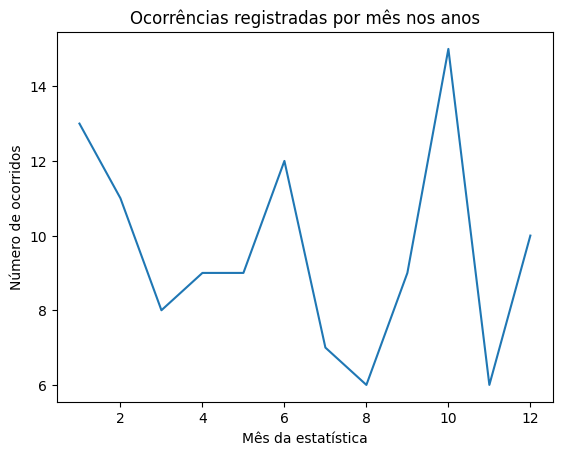

In [89]:
df = sheet.groupby('MÊS ESTATISTICA')['MÊS ESTATISTICA'].count()
df.plot(title="Ocorrências registradas por mês nos anos", xlabel="Mês da estatística", ylabel="Número de ocorridos")
plt.show()


Como podemos ver, as piores épocas são no fim/começo de ano (dezembro a fevereiro), meio do ano (junho) e outubro.

In [90]:
df = sheet.groupby('LOGRADOURO')['LOGRADOURO'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
display(df)

df = sheet.groupby('DESC_TIPOLOCAL')['DESC_TIPOLOCAL'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
display(df)

,LOGRADOURO,count
20,da vedacao da divulgacao dos dados relativos,14
42,rua doutor cesario mota junior,7
21,estrada de itapecerica,4
80,rua voluntarios da patria,3
10,avenida doutor eneas carvalho de aguiar,3
14,avenida francisco falconi,2
39,rua domingos furtado,2
2,alameda rodrigo de brum,2
4,avenida celso garcia,2
25,praca da se,2


,DESC_TIPOLOCAL,count
6,via publica,59
5,saude,38
3,residencia,13
4,restaurante e afins,2
0,comercio e servicos,1
1,hospedagem,1
2,reparticao publica,1


Como podemos ver, os logradouros onde mais se cometem crimes são a "rua doutor cesario mota junior", a "estrada de itapecerica", a "rua voluntarios da patria" e a "avenida doutor eneas carvalho de aguiar".

Os tipos de locais com mais crimes LCSM são "via publica", "saude" e "residencia".

## Salvando o dataset processado

Agora basta salvar o dataset processado em um novo arquivo do excel.

In [91]:
# Salva a planilha de volta em um arquivo do excel
with pd.ExcelWriter('LCSM_PROCESSED.xlsx') as writer:
    sheet.to_excel(writer)